In [74]:
import os
from dotenv import load_dotenv
load_dotenv()

import pandas as pd
from fredapi import Fred

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [72]:
sns.set_theme()
sns.set(font_scale=1.3)

# Load Fred API with key from secrets .env file
fred = Fred(api_key=os.environ.get('FRED_API_KEY'))

In [67]:
permits_df = fred.get_series('PERMIT')
permits_df.name = 'units_permitted'

completions_df = fred.get_series('COMPUTSA')
completions_df.name = 'units_completed'

housing_df = pd.merge(
    permits_df,
    completions_df,
    how='outer',
    left_index=True,
    right_index=True,
)

# Units are in thousands
housing_df = housing_df*1000

housing_df['permits_minus_completions'] = housing_df['units_permitted']-housing_df['units_completed']

housing_df

,units_permitted,units_completed,permits_minus_completions
1960-01-01,1092000.0,NaN,NaN
1960-02-01,1088000.0,NaN,NaN
1960-03-01,955000.0,NaN,NaN
1960-04-01,1016000.0,NaN,NaN
1960-05-01,1052000.0,NaN,NaN
...,...,...,...
2021-10-01,1653000.0,1255000.0,398000.0
2021-11-01,1717000.0,1404000.0,313000.0
2021-12-01,1885000.0,1333000.0,552000.0
2022-01-01,1895000.0,1236000.0,659000.0


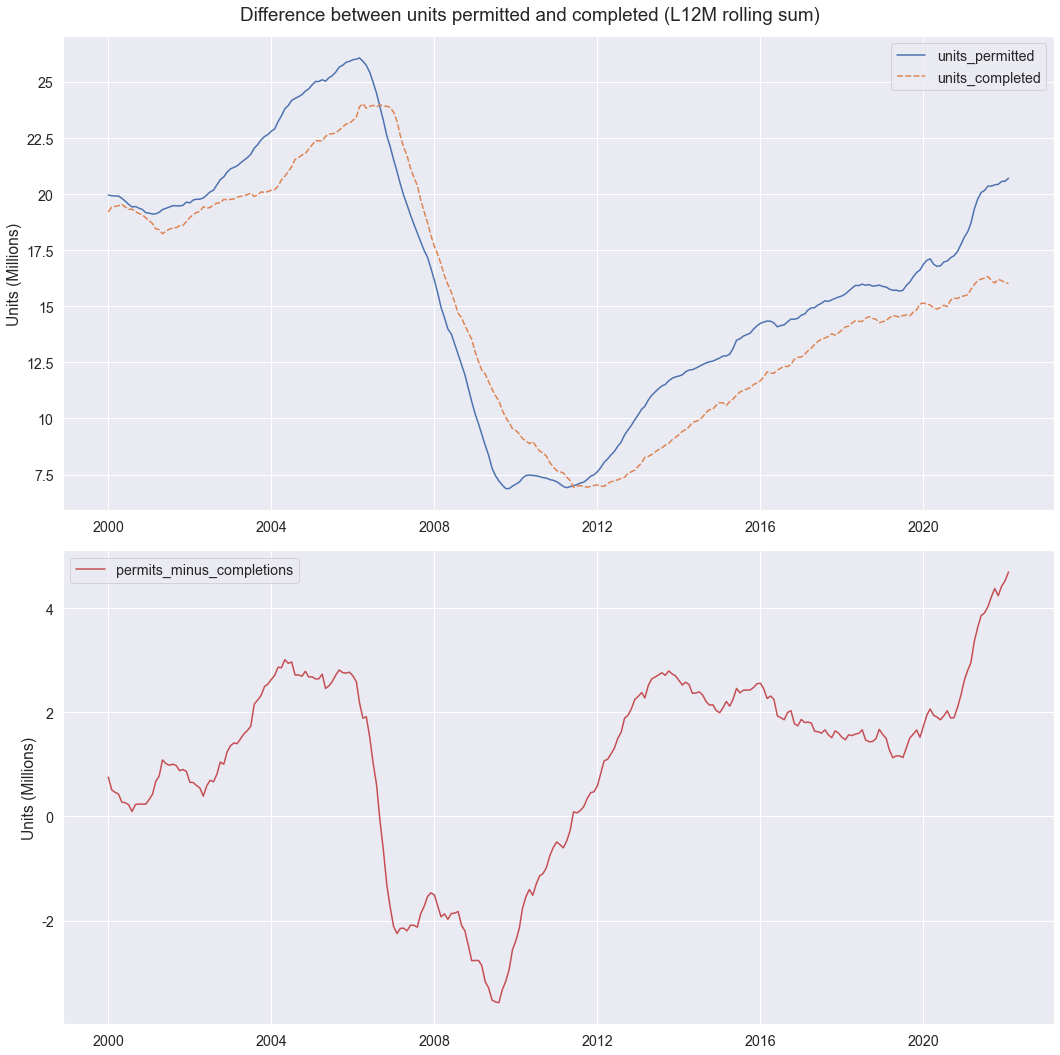

In [82]:
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1_000_000))

# Get 12 month rolling values
housing_12_month_rolling_df = housing_df.rolling(12).sum()

# Limit chart to 21st century and reshape to long for seaborn
cond = housing_12_month_rolling_df.index >= pd.Timestamp(2000, 1, 1)
long_df = housing_12_month_rolling_df[cond]

fig, axes = plt.subplots(2, 1, figsize=(15,15))
axes = axes.ravel()

ax = axes[0]
top_chart = ['units_permitted', 'units_completed']
sns.lineplot(data=long_df[left_axis], ax=ax)
ax.yaxis.set_major_formatter(ticks_y)
ax.set_ylabel('Units (Millions)')

# Plot deficit on bottom axes
ax = axes[1]
bottom_chart = ['permits_minus_completions']
sns.lineplot(data=long_df[right_axis], ax=ax, palette=['r'])
ax.yaxis.set_major_formatter(ticks_y)
ax.set_ylabel('Units (Millions)')

fig.suptitle('Difference between units permitted and completed (L12M rolling sum)')
fig.tight_layout()

plt.show()